In [6]:
# Library imports
import tensorflow as tf
import numpy as np
keras = tf.keras
import matplotlib.pyplot as plt
import os
import sys
import cProfile

In [4]:
# Add src directory to path for local imports
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Local imports
from utils import gpu_grow_memory

In [5]:
gpu_grow_memory()

In [7]:
tf.executing_eagerly()

True

In [8]:
x = [[2.0]]
m = tf.matmul(x, x)
print(f'hello.  m = {m}')

hello.  m = [[4.]]


In [9]:
a = tf.constant([[1,2], [3,4]])
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [10]:
b = tf.add(a, 1)
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [11]:
print(a*b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [17]:
def fizzbuzz(max_num):
    counter = tf.constant(0)
    max_num = tf.convert_to_tensor(max_num)
    for num in range(1, max_num.numpy() + 1):
        if int(num % 15) == 0:
            print('FizzBuzz')
        elif int(num % 3) == 0:
            print('Fizz')
        elif int(num % 5) == 0:
            print('Buzz')
        else:
            print(int(num))
        counter += 1

In [18]:
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


In [19]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
    loss = w * w
grad = tape.gradient(loss, w)
print(grad)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


In [21]:
(mnist_img, mnist_label), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(mnist_img[..., tf.newaxis]/255.0, tf.float32),
     tf.cast(mnist_label, tf.int64)))
dataset = dataset.shuffle(1024).batch(32)

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, [3,3], activation='relu', input_shape=(None, None, 1)),
    tf.keras.layers.Conv2D(16, [3,3], activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10)
])

In [28]:
for images, labels in dataset.take(1):
    print(f'images[0].shape={images[0].shape}')
    print(f'logits[0]={model(images[0:1]).numpy()}')

images[0].shape=(28, 28, 1)
logits[0]=[[-0.0051801   0.01650383  0.00186019 -0.09211739  0.00935774 -0.0289663
  -0.00483622 -0.04873506  0.01437225 -0.00149763]]


In [36]:
optimizer = tf.optimizers.Adam()
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
hist_loss = []

In [37]:
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = model(images, training=True)
        tf.debugging.assert_equal(logits.shape, (32,10))
        loss_value = loss_func(labels, logits)
    hist_loss.append(loss_value.numpy().mean())
    trn_vars = model.trainable_variables
    grads = tape.gradient(loss_value, trn_vars)
    optimizer.apply_gradients(zip(grads, trn_vars))

In [38]:
def train():
    for epoch in range(3):
        for batch, (images, labels) in enumerate(dataset):
            train_step(images, labels)
            print(f'Finished epoch {epoch}')

In [39]:
train()

Text(0, 0.5, 'Loss [entropy]')

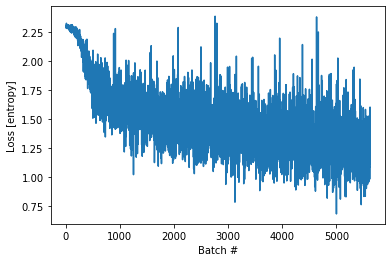

In [41]:
plt.plot(hist_loss)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

In [47]:
class LinearModel(tf.keras.Model):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.W = tf.Variable(5.0, name='weight')
        self.b = tf.Variable(10.0, name='bias')
    def call(self, inputs):
        return inputs * self.W + self.b

In [48]:
num_examples = 2000
inputs_trn = tf.random.normal([num_examples])
noise = tf.random.normal([num_examples])
outputs_trn = inputs_trn * 3.0 + 2.0 + noise

In [53]:
def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.reduce_mean(tf.square(error))

In [54]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
        return tape.gradient(loss_value, [model.W, model.b])

In [60]:
model = LinearModel()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

for i in range(300):
    grads = grad(model, inputs_trn, outputs_trn)
    optimizer.apply_gradients(zip(grads, [model.W, model.b]))
    if (i % 20) == 0:
        loss_value = loss(model, inputs_trn, outputs_trn)
        print(f'Loss at step {i:03d} : {loss_value:.3f}')

loss_value = loss(model, inputs_trn, outputs_trn)        
print(f'Final loss {loss_value:.3f}')
print(f'W={model.W.numpy():5.3f}, b={model.b.numpy():5.3f}')

Loss at step 000 : 66.112
Loss at step 020 : 30.247
Loss at step 040 : 14.142
Loss at step 060 : 6.909
Loss at step 080 : 3.659
Loss at step 100 : 2.199
Loss at step 120 : 1.542
Loss at step 140 : 1.247
Loss at step 160 : 1.114
Loss at step 180 : 1.055
Loss at step 200 : 1.028
Loss at step 220 : 1.016
Loss at step 240 : 1.010
Loss at step 260 : 1.008
Loss at step 280 : 1.007
Final loss 1.006
W=2.990, b=1.997


In [61]:
if tf.test.is_gpu_available():
  with tf.device("gpu:0"):
    v = tf.Variable(tf.random.normal([1000, 1000]))
    v = None  # v no longer takes up GPU memory

In [62]:
x = tf.Variable(10.0)
checkpoint = tf.train.Checkpoint(x=x)

x.assign(2.0)
checkpoint_path = './ckpt/'
checkpoint.save(checkpoint_path)

'./ckpt/-1'

In [63]:
x.assign(11.0)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))
print(x)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>


In [64]:
m = tf.keras.metrics.Mean('loss')
m(0.0)
m(5.0)
m.result()

<tf.Tensor: id=1045123, shape=(), dtype=float32, numpy=2.5>

In [65]:
m([8,9])
m.result()

<tf.Tensor: id=1045138, shape=(), dtype=float32, numpy=5.5>

In [66]:
def line_search_step(f, x0, rate=1.0):
    with tf.GradientTape as tape:
        tape.watch(x0)
        y0 = f(x0)
    grad = tape.gradient(y, x0)
    grad_norm = tf.reduce_sum(grad*grad)
    y = y0
    while y > y0 - rate * grad_norm:
        x = x0 - rate * grad
        y = f(x)
        rate /= 2.0
    return x, y

In [67]:
@tf.custom_gradient
def clip_gradient_by_norm(x, norm):
    y = tf.identity(x)
    def grad_fn(dresult):
        return [tf.clip_by_norm(dresult, norm), None]
    return y, grad_fn

In [68]:
import time

In [69]:
def profile(x, steps):
    tf.matmul(x, x)
    start = time.time()
    for i in range(steps):
        x = tf.matmul(x, x)
    _ = x.numpy()
    end = time.time()
    return end - start

In [72]:
shape = (1000, 1000)
steps = 200
print(f'Time to multiply {shape} matrix {steps} times:')

with tf.device('/cpu:0'):
    x = tf.random.normal(shape)
    elapsed_cpu = profile(x, steps)
print(f'CPU: {elapsed_cpu:6.4f}')
    
with tf.device('/gpu:0'):
    x = tf.random.normal(shape)
    elapsed_gpu = profile(x, steps)
print(f'GPU: {elapsed_gpu:6.4f}')

Time to multiply (1000, 1000) matrix 200 times:
CPU:  3.983
GPU: 0.04687
